In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [3]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

'<|endoftext|>'

In [5]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [6]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        caption = f"{caption}<|endoftext|>"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [7]:
# fashion dataset
base_path = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images')
df = pd.read_csv('/kaggle/input/fashion-captioning/fashion.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['image'] = df['image'].map(lambda x:base_path / x.strip())
# df['caption'] = df['caption'].map(lambda x:x.strip().lower())
df.head()

,image,caption
0,/kaggle/input/fashion-product-images-dataset/f...,Turtle Check Men Navy Blue Shirt
1,/kaggle/input/fashion-product-images-dataset/f...,Peter England Men Party Blue Jeans
2,/kaggle/input/fashion-product-images-dataset/f...,Titan Women Silver Watch
3,/kaggle/input/fashion-product-images-dataset/f...,Manchester United Men Solid Black Track Pants
4,/kaggle/input/fashion-product-images-dataset/f...,Puma Men Grey T-shirt


In [8]:
df.shape

(44441, 2)

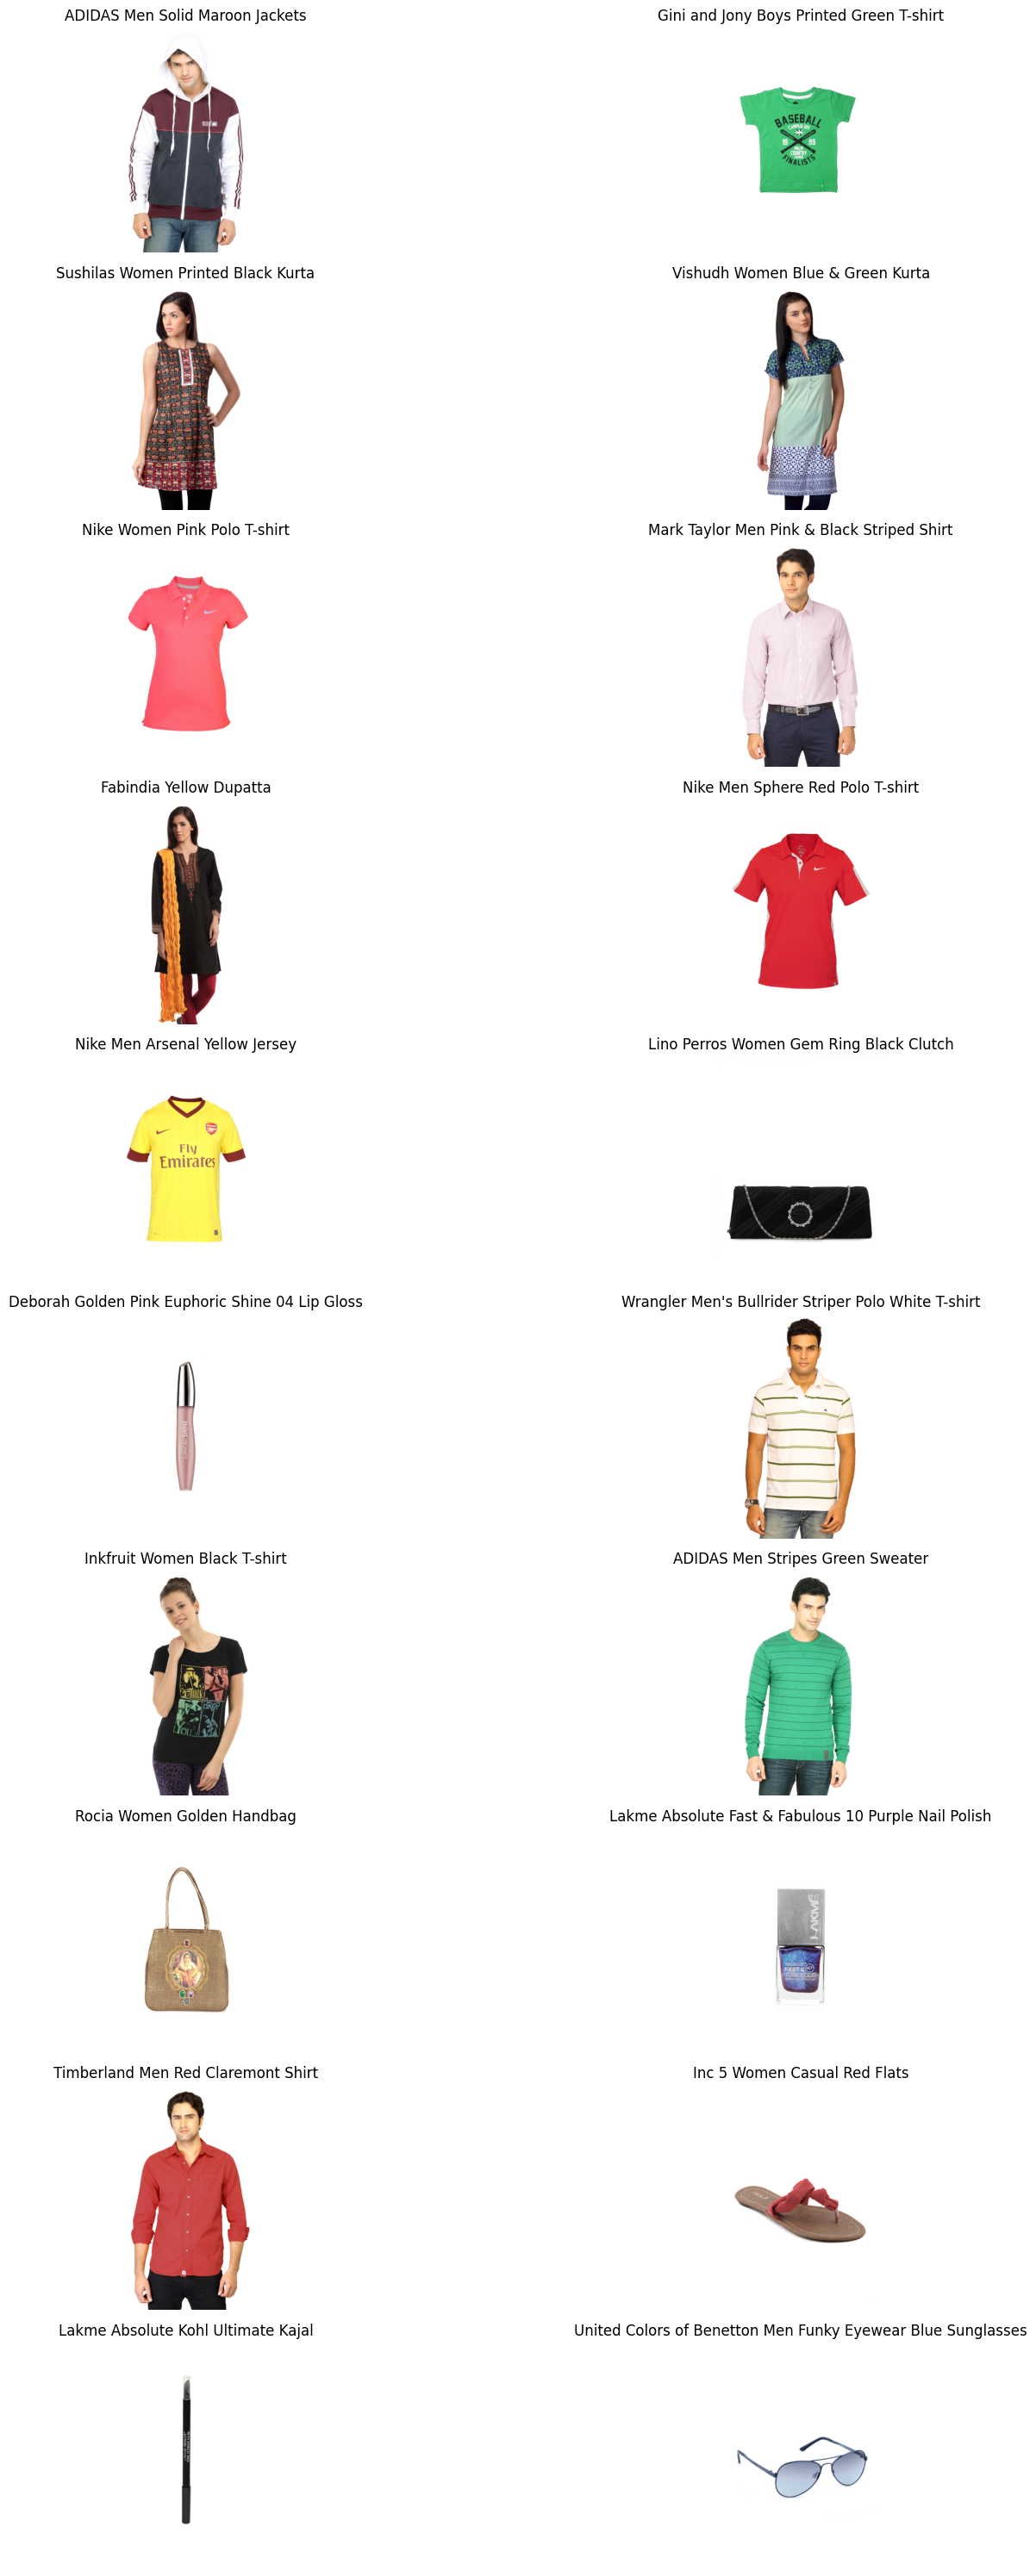

In [9]:
sampled_df = df.sample(n=20)
fig, axs = plt.subplots(10, 2, figsize=(20, 30))

for i, row in enumerate(sampled_df.iterrows()):
    ax = axs[i // 2, i % 2]
    image_path = row[1]['image']
    caption = row[1]['caption']
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(caption)

plt.tight_layout()
plt.show()

In [10]:
train_df, val_df = train_test_split(df,test_size=0.1)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(len(train_df),len(val_df))

39996 4445


In [11]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

In [12]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

In [13]:
dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=2,collate_fn=collate_fn)
_,c,l = next(iter(dl))
print(c[0])
print(l[0])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([49278,  6926, 44498,  2448,    69,  2454, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256])
tensor([ 6926, 44498,  2448,    69,  2454, 50256,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100])


In [14]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [15]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [16]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [17]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

In [18]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.config = config
        
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)
        
        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        
    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)
    
    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)
        
        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable
                
        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')
        
    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)
            
        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True
        
    @classmethod    
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]
        
        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
            
        model.load_state_dict(sd)
        
        return model
    
    def forward(self,image,input_ids,labels=None):
        
        image = self.patch_embed(image)
        image = self._pos_embed(image)
        
        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)
        
        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)
        
        input_ids = self.transformer.ln_f(input_ids)
        
        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits
    
    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
            
        return sequence.cpu().flatten()

In [19]:
class Trainer:
    def __init__(self,model_config,train_config, dls):
        
        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device
        
        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)
        
        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')
        
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.scaler = GradScaler()
        
        self.train_dl, self.val_dl = dls
        
        total_steps = len(self.train_dl)
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )
        
#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)
        
        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None
        
        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])
            
        
    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')
        
        
    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)
    
    
    def train_one_epoch(self,epoch):
        
        prog = tqdm(self.train_dl,total=len(self.train_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)
                
                running_loss += loss.item()
                
                prog.set_description(f'train loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        
        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss,train_pxp)
        
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        prog = tqdm(self.val_dl,total=len(self.val_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                running_loss += loss.item()
                
                prog.set_description(f'valid loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        
        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss,val_pxp)
        
        return val_pxp
        
        
    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()
       
    
    def fit(self,):
        
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        
        for epoch in prog:
            
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')
                
            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)
            
            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()
            
            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()
            
            print(self.metrics.tail(1))
            
            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()
                
        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
           
        
    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):
        
        self.model.eval()
        
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id
        
        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)
        
        return caption

In [20]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 5,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-4,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 32
)

In [21]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=train_config.batch_size,
                                       shuffle=True,
                                       pin_memory=True,
                                       num_workers=2,
                                       persistent_workers=True,
                                       collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,
                                     batch_size=train_config.batch_size,
                                     shuffle=False,
                                     pin_memory=True,
                                     num_workers=2,
                                     persistent_workers=True,
                                     collate_fn=collate_fn)

In [22]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

total_frozen_params=210236928
trainable parameters: 28366848


In [23]:
trainer.fit()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
0    7.09842      1210.053855  4.222842      68.227088
saving best model...
unfreezing GPT2 entirely...


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  train_loss train_perplexity val_loss val_perplexity
1   2.513869        12.352635  1.69683       5.456625
saving best model...
total_frozen_params=0


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
2     1.6078         4.991818  1.320658       3.745885
saving best model...


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
3   1.223665         3.399625  1.163914       3.202443
saving best model...


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
4   1.038429         2.824777  1.133119       3.105327
saving best model...


{'best_perplexity': 3.105326730031099, 'best_epoch': 4}

In [24]:
trainer.metrics

,train_loss,train_perplexity,val_loss,val_perplexity
0,7.09842,1210.053855,4.222842,68.227088
1,2.513869,12.352635,1.69683,5.456625
2,1.6078,4.991818,1.320658,3.745885
3,1.223665,3.399625,1.163914,3.202443
4,1.038429,2.824777,1.133119,3.105327


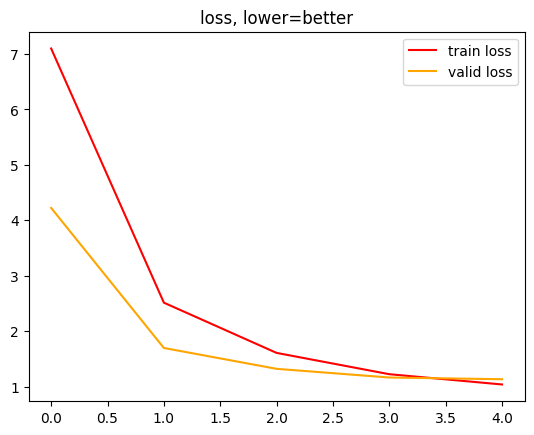

In [25]:
plt.plot(trainer.metrics['train_loss'],color='red',label='train loss')
plt.plot(trainer.metrics['val_loss'],color='orange',label='valid loss')
plt.title('loss, lower=better')
plt.legend()
plt.show()

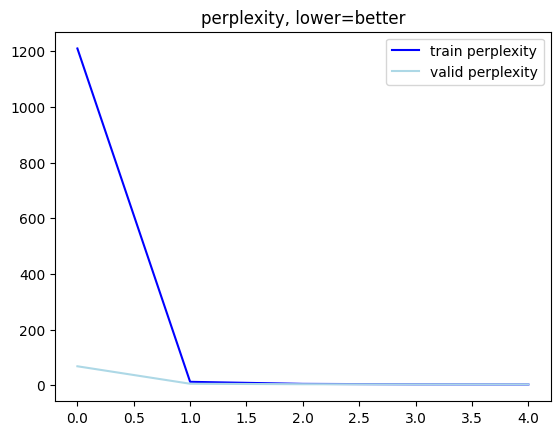

In [26]:
plt.plot(trainer.metrics['train_perplexity'],color='blue',label='train perplexity')
plt.plot(trainer.metrics['val_perplexity'],color='lightblue',label='valid perplexity')
plt.title('perplexity, lower=better')
plt.legend()
plt.show()

In [27]:
trainer.load_best_model()

In [28]:
test = '/kaggle/input/fashion-captioning/adidas-tee.jpeg'
cap = trainer.generate_caption(test)

go Active Gear USA Men Printed Grey Tshirts


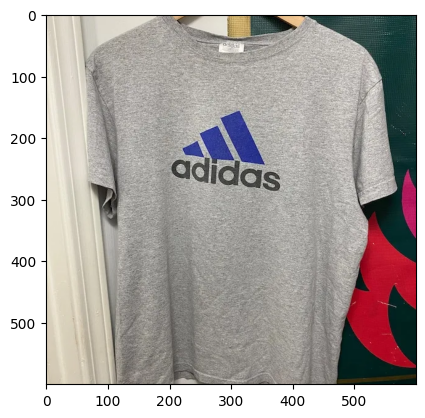

In [29]:
print(cap)
plt.imshow(Image.open(test).convert('RGB'))
plt.show()

In [30]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [31]:
from fastbook import *
from fastai.vision.widgets import *

In [32]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [33]:
ims = search_images_ddg(cap)
len(ims)

200

In [34]:
dest = []
for i in range(5):
    temp = f'{cap}{i}.jpg'
    dest.append(temp)
    download_url(ims[i], temp)

In [35]:
import matplotlib.pyplot as plt

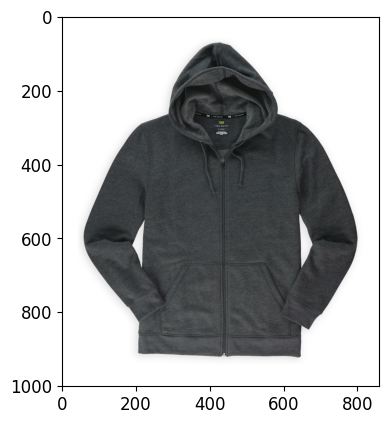

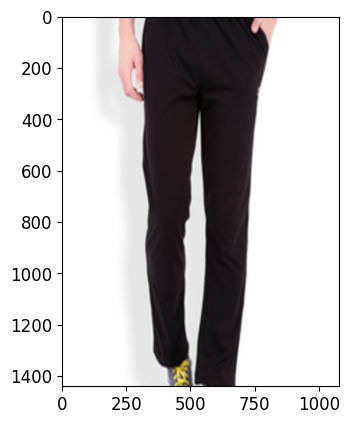

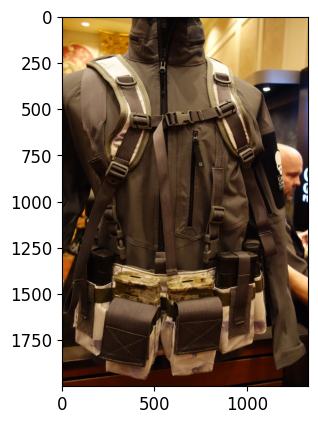

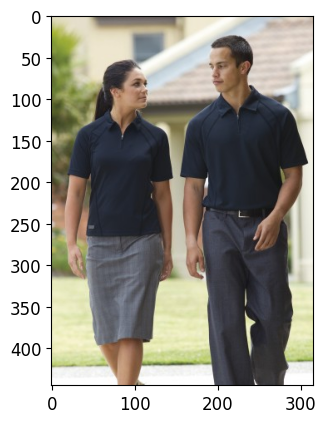

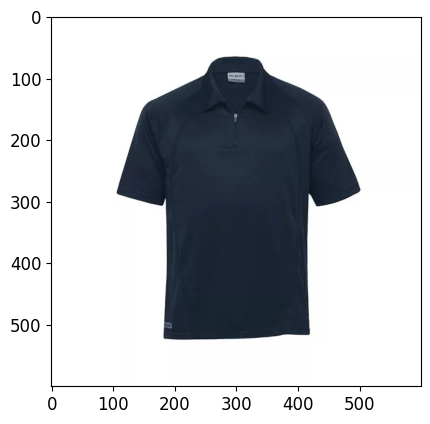

In [36]:
for i in range(5):
    im = Image.open(dest[i])
    im.to_thumb(128,128)
    plt.imshow(im)
    plt.show()

In [37]:
def reverseImageSearch(dest):
    cap = trainer.generate_caption(dest)
    print(cap)
    plt.imshow(Image.open(dest).convert('RGB'))
    plt.show()
    ims = search_images_ddg(cap)
    dest = []
    for i in range(5):
        temp = f'{cap}{i}.jpg'
        dest.append(temp)
        download_url(ims[i], temp, show_progress=False)
    for i in range(5):
        im = Image.open(dest[i])
        im.to_thumb(128,128)
        plt.imshow(im)
        plt.show()

luxe Women Black Messenger Bag


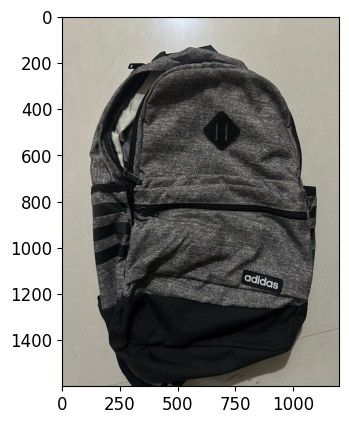

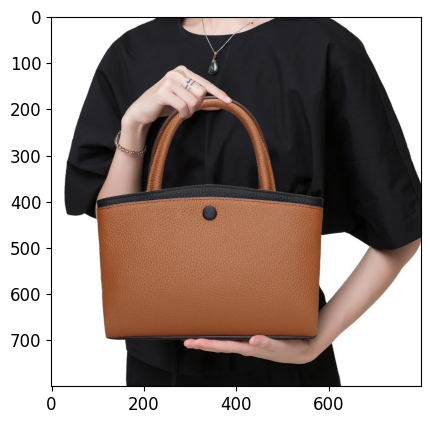

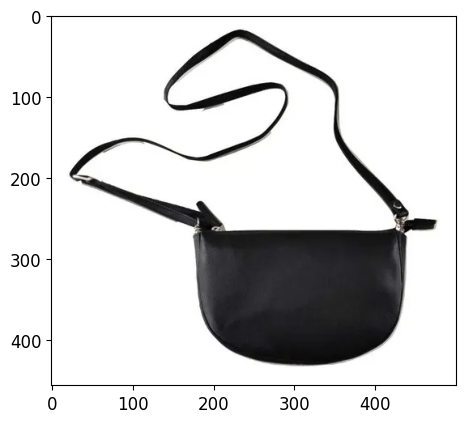

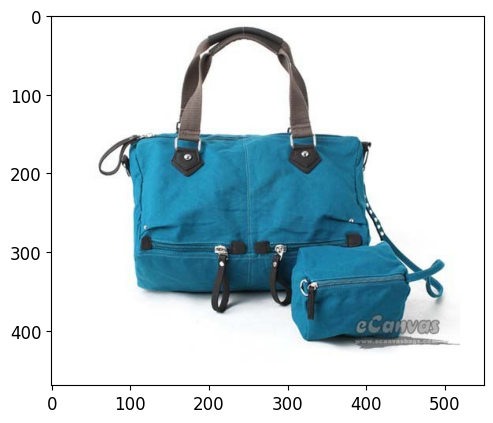

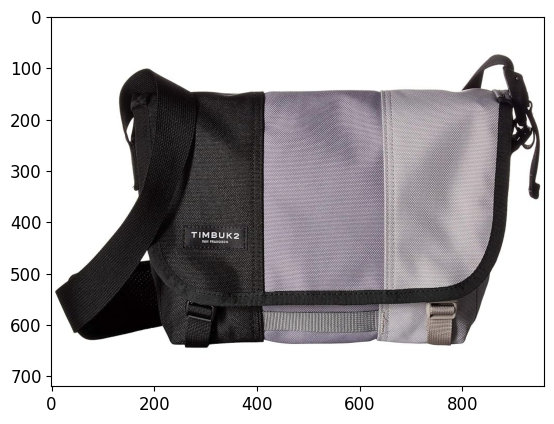

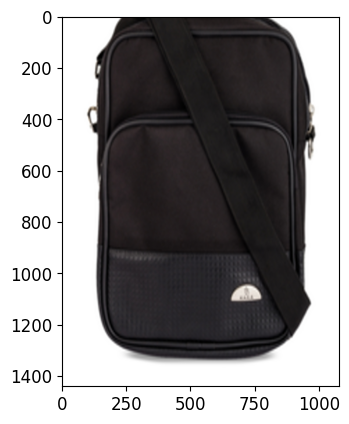

In [38]:
reverseImageSearch('/kaggle/input/fashion-captioning/adidas-bag.jpeg')

In [39]:
??download_url